In [1]:
!pip install -q transformers datasets evaluate sentencepiece accelerate

import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
import evaluate

# Setup Device (GPU preferred)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
Using device: cuda


In [2]:
MODEL_CHECKPOINT = "t5-base"
MAX_INPUT_LENGTH = 384  # Context + Question
MAX_TARGET_LENGTH = 64  # Answer length
BATCH_SIZE = 8          # Low batch size to prevent OOM
GRAD_ACCUMULATION = 4   # Effective batch size = 32
LEARNING_RATE = 2e-5
EPOCHS = 2

In [3]:
from transformers import AutoTokenizer # Use AutoTokenizer instead of T5Tokenizer

print("Loading SQuAD dataset...")
raw_datasets = load_dataset("rajpurkar/squad")

# FIX: Use AutoTokenizer which loads T5TokenizerFast by default
# This prevents the "piece id out of range" error
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def preprocess_function(examples):
    """
    Format: "question: {q} context: {c}"
    Target: "{answer}"
    """
    inputs = [f"question: {q} context: {c}" for q, c in zip(examples["question"], examples["context"])]

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding="max_length"
    )

    # Tokenize targets (answers)
    targets = [answers["text"][0] for answers in examples["answers"]]

    labels = tokenizer(
        text_target=targets,
        max_length=MAX_TARGET_LENGTH,
        truncation=True
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Reduce dataset size for debugging if needed, otherwise use full
dataset_train = raw_datasets["train"]
dataset_val = raw_datasets["validation"]

print("Preprocessing training data...")
tokenized_train = dataset_train.map(preprocess_function, batched=True, remove_columns=raw_datasets["train"].column_names)
print("Preprocessing validation data...")
tokenized_val = dataset_val.map(preprocess_function, batched=True, remove_columns=raw_datasets["validation"].column_names)

Loading SQuAD dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Preprocessing training data...


Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Preprocessing validation data...


Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [4]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_CHECKPOINT)
model.to(device)

# Data Collator handles dynamic padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
import numpy as np

# Load metric
metric = evaluate.load("squad")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # --- FIX START ---
    # The tokenizer cannot decode -100, so we must replace it with the pad token ID
    # We apply this to BOTH predictions and labels just to be safe.

    # 1. Clean Predictions
    predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)

    # 2. Clean Labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # --- FIX END ---

    # Now it is safe to decode
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Simple Exact Match approximation for logging
    match_count = 0
    for pred, label in zip(decoded_preds, decoded_labels):
        if pred.strip().lower() == label.strip().lower():
            match_count += 1

    return {"exact_match_approx": match_count / len(decoded_preds)}

In [6]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

args = Seq2SeqTrainingArguments(
    output_dir="./t5-squad-finetuned",
    eval_strategy="epoch",            # CHANGED: evaluation_strategy -> eval_strategy
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUMULATION,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=EPOCHS,
    predict_with_generate=True,       # Crucial for Seq2Seq eval
    fp16=torch.cuda.is_available(),   # Mixed precision for GPU
    logging_dir='./logs',
    logging_steps=100,
    report_to="none"                  # Disable WandB
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val.select(range(500)),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1398192412.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [7]:
print("Starting Training...")
trainer.train()

# Save final model
trainer.save_model("./final_t5_squad_model")
tokenizer.save_pretrained("./final_t5_squad_model")
print("Training Complete & Model Saved!")

Starting Training...


Epoch,Training Loss,Validation Loss,Exact Match Approx
1,0.286600,0.306070,0.766000
2,0.269300,0.307748,0.762000


Training Complete & Model Saved!


In [8]:
def generate_answer(question, context):
    input_text = f"question: {question} context: {context}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=MAX_INPUT_LENGTH, truncation=True).to(device)

    outputs = model.generate(
        inputs.input_ids,
        max_length=MAX_TARGET_LENGTH,
        num_beams=4,
        early_stopping=True
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print("\n--- Inference Demo ---")
ctx = "The normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France."
que = "When did the Normans give their name to Normandy?"

pred = generate_answer(que, ctx)
print(f"Context: {ctx}")
print(f"Question: {que}")
print(f"Predicted Answer: {pred}")


--- Inference Demo ---
Context: The normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France.
Question: When did the Normans give their name to Normandy?
Predicted Answer: 10th and 11th


In [9]:
ctx = "The normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France."

# Pertanyaan 1: Lokasi (Where)
que1 = "Where is Normandy located?"
# Ekspektasi: "a region in France" atau "France"

# Pertanyaan 2: Entitas Nama (What)
que2 = "What is the Latin name for the Normans?"
# Ekspektasi: "Normanni"

# Pertanyaan 3: Subjek (Who)
que3 = "Who gave their name to Normandy?"
# Ekspektasi: "The normans" or "the people"

# --- Code Eksekusi ---
print(f"Q1 Answer: {generate_answer(que1, ctx)}")
print(f"Q2 Answer: {generate_answer(que2, ctx)}")
print(f"Q3 Answer: {generate_answer(que3, ctx)}")

Q1 Answer: France
Q2 Answer: Normanni
Q3 Answer: normans


In [10]:
# Konteks tentang Gravitasi
ctx_science = "Gravity is a fundamental interaction which causes mutual attraction between all things that have mass or energy. Gravity is, by far, the weakest of the four fundamental interactions, approximately 10^38 times weaker than the strong interaction."

# Pertanyaan 1: Definisi
que_sci_1 = "What causes mutual attraction between things with mass?"
# Ekspektasi: "Gravity"

# Pertanyaan 2: Perbandingan
que_sci_2 = "Is gravity stronger or weaker than the strong interaction?"
# Ekspektasi: "weaker" atau "the weakest"

# --- Code Eksekusi ---
print(f"Science Q1: {generate_answer(que_sci_1, ctx_science)}")
print(f"Science Q2: {generate_answer(que_sci_2, ctx_science)}")

Science Q1: Gravity
Science Q2: weaker


In [11]:
# Konteks tentang Albert Einstein
ctx_bio = "Albert Einstein was born in Germany in 1879. He is best known for developing the theory of relativity. In 1921, he received the Nobel Prize in Physics for his explanation of the photoelectric effect."

# Pertanyaan 1: Kapan (When)
que_bio_1 = "When was Albert Einstein born?"
# Ekspektasi: "1879"

# Pertanyaan 2: Apa (What - Reasoning)
que_bio_2 = "Why did Einstein receive the Nobel Prize?"
# Ekspektasi: "for his explanation of the photoelectric effect"

# --- Code Eksekusi ---
print(f"Bio Q1: {generate_answer(que_bio_1, ctx_bio)}")
print(f"Bio Q2: {generate_answer(que_bio_2, ctx_bio)}")

Bio Q1: 1879
Bio Q2: the photoelectric effect


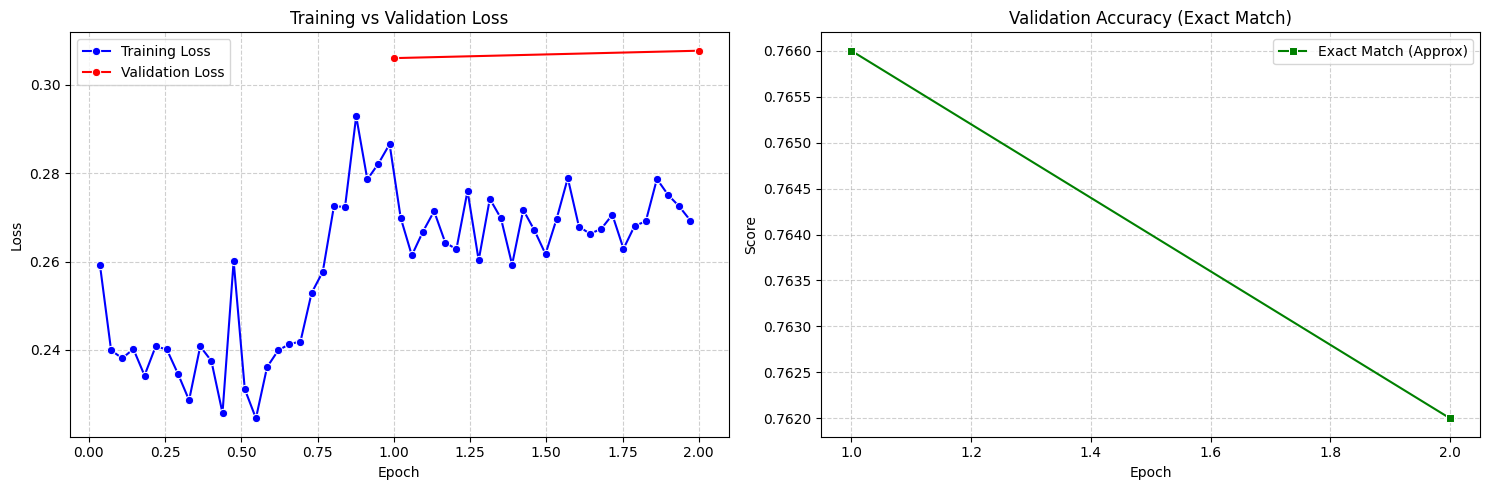

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_training_history(trainer):
    # 1. Ambil history dari trainer
    log_history = trainer.state.log_history

    # Konversi ke DataFrame
    df = pd.DataFrame(log_history)

    # 2. Pisahkan data Training dan Validation
    # Data training biasanya dicatat per 'step', validation per 'epoch'
    train_loss = df[df['loss'].notnull()][['epoch', 'loss']]
    val_loss = df[df['eval_loss'].notnull()][['epoch', 'eval_loss', 'eval_exact_match_approx']]

    # 3. Setup Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # --- Plot 1: Learning Curve (Loss) ---
    sns.lineplot(data=train_loss, x='epoch', y='loss', label='Training Loss', ax=axes[0], color='blue', marker='o')
    sns.lineplot(data=val_loss, x='epoch', y='eval_loss', label='Validation Loss', ax=axes[0], color='red', marker='o')

    axes[0].set_title("Training vs Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # --- Plot 2: Metrics Evolution (Exact Match) ---
    # Hanya ada di validation steps
    if 'eval_exact_match_approx' in val_loss.columns:
        sns.lineplot(data=val_loss, x='epoch', y='eval_exact_match_approx', label='Exact Match (Approx)', ax=axes[1], color='green', marker='s')
        axes[1].set_title("Validation Accuracy (Exact Match)")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Score")
        axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Jalankan fungsi
plot_training_history(trainer)

In [13]:
import random
from IPython.display import display, HTML

def visualize_predictions(model, tokenizer, dataset, num_samples=5):
    model.eval()
    samples = dataset.select(random.sample(range(len(dataset)), num_samples))

    results = []
    print("Generating predictions for random samples...")

    for example in samples:
        context = example['context']
        question = example['question']
        # Jawaban asli di SQuAD bisa lebih dari satu, kita ambil yang pertama
        ground_truth = example['answers']['text'][0] if len(example['answers']['text']) > 0 else ""

        # Generate Prediksi
        pred_answer = generate_answer(question, context)

        results.append({
            "Question": question,
            "Ground Truth": ground_truth,
            "Model Prediction": pred_answer,
            "Match?": "✅" if pred_answer.strip().lower() in ground_truth.strip().lower() else "❌"
        })

    # Buat DataFrame
    df_results = pd.DataFrame(results)

    # Styling agar mudah dibaca
    display(HTML("<h3>🔍 Qualitative Analysis: Model Predictions</h3>"))
    display(df_results.style.set_properties(**{'text-align': 'left'}).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'left')]}
    ]))

# Jalankan visualisasi (menggunakan dataset validasi asli sebelum diproses)
# Pastikan Anda menggunakan dataset mentah (raw_datasets['validation']) agar teksnya masih terbaca manusia
visualize_predictions(model, tokenizer, raw_datasets["validation"], num_samples=5)

Generating predictions for random samples...


,Question,Ground Truth,Model Prediction,Match?
0,How might gravity effects be observed differently according to Newton?,at larger distances.,at larger distances,✅
1,What is the prize offered for finding a solution to P=NP?,"$1,000,000","$1,000,000 prize",❌
2,What color were the Bronco's uniforms in Super Bowl 50?,white,white,✅
3,What are the little tentacles that cydippids have called?,tentilla,tentilla,✅
4,Which lunar probe was near the Apollo 12 crew's landing site?,Surveyor 3,Surveyor 3,✅


In [14]:
from transformers import T5ForConditionalGeneration, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch

# 1. Tentukan Path Checkpoint
checkpoint_path = "/content/t5-squad-finetuned/checkpoint-2738"
print(f"Loading model from: {checkpoint_path}")

# 2. Load Model & Tokenizer dari Checkpoint tersebut
# Kita memuat ulang agar yakin yang diuji adalah benar-benar checkpoint 2738
model_ckpt = T5ForConditionalGeneration.from_pretrained(checkpoint_path)
tokenizer_ckpt = AutoTokenizer.from_pretrained(checkpoint_path)

# Pindahkan ke GPU jika ada
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt.to(device)

# 3. Siapkan Arguments Khusus Evaluasi
# Kita buat output_dir sementara karena kita hanya ingin evaluasi, bukan training
eval_args = Seq2SeqTrainingArguments(
    output_dir="/tmp/eval_temp",
    per_device_eval_batch_size=8,
    predict_with_generate=True,   # Wajib untuk T5 agar menghasilkan teks
    fp16=torch.cuda.is_available(),
    report_to="none"
)

# 4. Inisialisasi Trainer Khusus Evaluasi
trainer_eval = Seq2SeqTrainer(
    model=model_ckpt,
    args=eval_args,
    eval_dataset=tokenized_val,   # Menggunakan dataset validasi yang sudah diproses sebelumnya
    tokenizer=tokenizer_ckpt,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 5. Jalankan Evaluasi
print("Starting Evaluation on Checkpoint 2738...")
metrics = trainer_eval.evaluate()

# 6. Tampilkan Hasil
print("\n--- Evaluation Results (Checkpoint 2738) ---")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

Loading model from: /content/t5-squad-finetuned/checkpoint-2738


/tmp/ipython-input-1412396502.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_eval = Seq2SeqTrainer(


Starting Evaluation on Checkpoint 2738...



--- Evaluation Results (Checkpoint 2738) ---
eval_loss: 0.3237
eval_model_preparation_time: 0.0044
eval_exact_match_approx: 0.6152
eval_runtime: 760.2589
eval_samples_per_second: 13.9030
eval_steps_per_second: 1.7390
